# Basic mitigated VQE

In [1]:
import numpy as np
import scipy.optimize as opt
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
import mthree

## Setup problem

Here we define the Hamiltonian in terms of `(coefficient, operator string)` pairs, where the right-most element of the strings correspond to qubit 0.

In [2]:
H_op = [(0.39793742484318045, 'YZ'), (-0.39793742484318045, 'ZI'),
       (-0.01128010425623538, 'ZZ'), (0.18093119978423156, 'XX')]

We also need to define our guess (ansatz) for the form of the target statevector:

In [3]:
ansatz = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cx')  

## Extract the needed data

First we need an array of the coefficients, and a list of the operator strings.

In [4]:
coeffs = np.array([item[0] for item in H_op], dtype=float)
op_strings = [item[1] for item in H_op]

Next, we need to make circuits that perform the needed post-rotations needed for the measurements defined by the `op_strings`.  We need a function to do this:

In [5]:
def opstr_to_meas_circ(op_str):
    """Takes a list of operator strings and makes circuit with the correct post-rotations for measurements.
    
    Parameters:
        op_str (list): List of strings representing the operators needed for measurements.
        
    Returns:
        list: List of circuits for measurement post-rotations
    """
    num_qubits = len(op_str[0])
    circs = []
    for op in op_str:
        qc = QuantumCircuit(num_qubits)
        for idx, item in enumerate(op):
            if item == 'X':
                qc.h(num_qubits-idx-1)
            elif item == 'Y':
                qc.sdg(num_qubits-idx-1)
                qc.h(num_qubits-idx-1)
        circs.append(qc)
    return circs

Next we actual grab the measurement circuits:

In [6]:
meas_circs = opstr_to_meas_circ(op_strings)

Having both the ansatz and measurement circuits in hand we can now combine them and add measurements.  (Qiskit does not let us combine circuits with classical registers to ones that do not.  Thus we have to do things in a bit of an odd way here)

In [7]:
full_circs = [ansatz.compose(meas_circs[kk]).measure_all(inplace=False) for kk in range(len(meas_circs))]

Lastly, we need the strings that will tell the expectation value function which diagonal operators to use.  Because we have added post-rotations to each circuit for the `X` and `Y` measurements, these strings need to be converted to `Z`:

In [8]:
meas_strings = [string.replace('X', 'Z').replace('Y', 'Z') for string in op_strings]
meas_strings

['ZZ', 'ZI', 'ZZ', 'ZZ']

## Run the problem

First we need to set the backend, and compile the circuits for it:

In [9]:
backend = FakeAthensV2()
trans_circs = transpile(full_circs, backend)

One example compield circuit is:

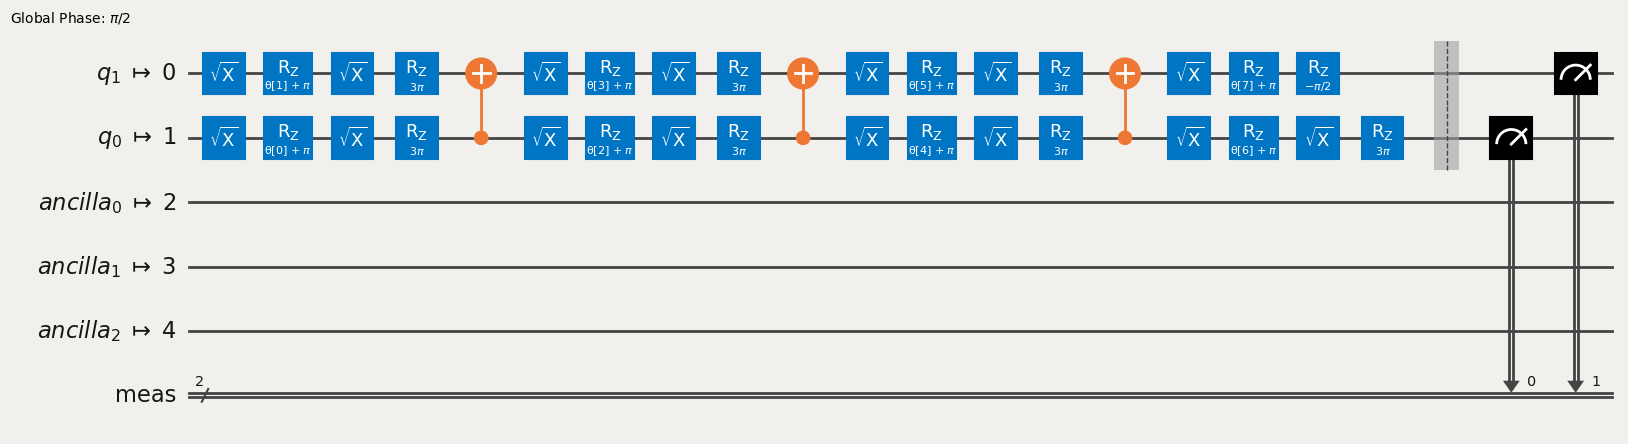

In [10]:
trans_circs[0].draw('mpl')

We now need to set the starting point of the VQE iterations.  This means selecting a set of initial parameters to pass to the parameterized circuits.  Here we select ones close to a solution vector:

In [11]:
num_params = ansatz.num_parameters
params = np.array([1.22253725, 0.39053752, 0.21462153, 5.48308027,
                   2.06984514, 3.65227416, 4.01911194, 0.35749589])
params += 0.05*(np.random.random(params.shape[0])-0.5)

Now we are in a position to actually calibrate the M3 mitigator and run the algorithm:

In [12]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system([0,1])

The function used to actually compute the cost function (energy) is given as:

In [13]:
def vqe_func(params, *args):
    # Attach parameters to the transpiled circuit variables
    bound_circs = [circ.assign_parameters(params) for circ in trans_circs]
    # Submit the job and get the resultant counts back
    counts = backend.run(bound_circs, shots=4096).result().get_counts()
    # Apply mitigation to get quasi-probabilities
    quasis = mit.apply_correction(counts, [0,1])
    # Evaluate the coefficients times each expectation value obtained from quasi-probabilities and sum.
    energy = np.sum(coeffs*quasis.expval(meas_strings))
    return energy

Finally, we can now execute the VQE function using one of the solvers from SciPy, returning the solution for the minimum energy and the associated parameters:

In [14]:
res = opt.minimize(vqe_func, params, method = 'COBYLA')

In [15]:
print(res.fun)
print(np.mod(res.x, 2*np.pi))

-0.4225174851539548
[1.19431989 0.47538226 0.23049561 5.42894984 2.03143571 3.66993543
 3.88204834 0.31311506]


The optimal solution is around: `-0.44841884382998787`